# Fine tunning modelo BERT para generación de recompensa

In [5]:
!pip install transformers

In [9]:
# Instalar librerías
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd


In [10]:
RANDOM_SEED = 21
MAX_LEN = 125
BATCH_SIZE = 32
DATASET_TRAIN1 = '/kaggle/input/empathetic/ED_train_p1.csv'
DATASET_TRAIN2 = '/kaggle/input/empathetic/ED_train_p2.csv'
DATASET_VALID = '/kaggle/input/empathetic/ED_train_p1.csv'
NCLASSES = 4

# Las siguentes lineas son necesarias?
#np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [11]:
df_train1 = pd.read_csv(DATASET_TRAIN1, sep = ';')
df_train2 = pd.read_csv(DATASET_TRAIN2, sep = ';')
df_valid = pd.read_csv(DATASET_VALID, sep = ';')


In [12]:
df_train1.head()
df_train1.dtypes

utterance     object
utterance2    object
emotion        int64
dtype: object

In [13]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

In [14]:
utterance1 = ""
utterance2 = ""
encoding = tokenizer.encode_plus(
    utterance1,
    utterance2,
    max_length = 125, # Numero máximo de palabras a codificar incluidos los tokens CLS y SEP
    truncation = True,
    add_special_tokens = True, # [CLS] y [SEP]
    return_token_type_ids = False,
    padding = 'max_length', # antes -->pad_to_max_length = True,
    return_attention_mask = True,
    return_tensors = 'pt'
)

In [15]:
class inputDataset(Dataset):
    def __init__(self, utte1, utte2, labels, tokenizer,max_len):
        self.utte1 = utte1
        self.utte2 = utte2
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.utte1) # Indica la longitud de la base de datos. Se toma la longitud de esta columna (que es un array aquí) como podría ser la utte2 ya que son iguales.

    def __getitem__(self, item):
        utterance1 = str(self.utte1[item])
        utterance2 = str(self.utte2[item])
        label = self.labels[item]
        encoding = tokenizer.encode_plus(
            utterance1,
            utterance2,
            max_length = self.max_len,
            truncation = True,
            add_special_tokens = True,
            return_token_type_ids = False,
            padding = 'max_length', # Antes era --> pad_to_max_length = True
            return_attention_mask = True,
            return_tensors = 'pt'
        )

        return {
            'utterance1': utterance1,
            'utterance2': utterance2,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)


        }

In [16]:
def data_loader(df, tokenizer, max_len, batch_size):
    dataset = inputDataset(
        utte1 = df.utterance.to_numpy(),
        utte2 = df.utterance2.to_numpy(),
        labels = df.emotion.to_numpy(),
        tokenizer = tokenizer,
        max_len = MAX_LEN
    )

    return DataLoader(dataset, batch_size = BATCH_SIZE, num_workers = 4)

In [17]:
train_data_loader1 = data_loader(df_train1, tokenizer, MAX_LEN, BATCH_SIZE)
train_data_loader2 = data_loader(df_train2, tokenizer, MAX_LEN, BATCH_SIZE)
valid_data_loader = data_loader(df_valid, tokenizer, MAX_LEN, BATCH_SIZE)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [18]:
# EL MODELO!

class BERTSentimentClassifier(nn.Module):

    def __init__(self, n_classes):
        super(BERTSentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.drop = nn.Dropout(p=0.4)
        self.linear = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        all_output, cls_output = self.bert(
            input_ids = input_ids,
            attention_mask = attention_mask,
            return_dict=False
        )
        drop_output = self.drop(cls_output)
        output = self.linear(drop_output)
        return output, all_output




In [19]:
model = BERTSentimentClassifier(NCLASSES)
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [20]:
# ENTRENAMIENTO 
# definición del entrenamiento
EPOCHS = 5
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps1 = len(train_data_loader1) * EPOCHS
total_steps2 = len(train_data_loader2) * EPOCHS

scheduler1 = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 0,
    num_training_steps = total_steps1
)

scheduler2 = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps = total_steps2
)
loss_fn = nn.CrossEntropyLoss().to(device)

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [21]:
# Iteración entrenamiento
def train_model(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0
    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        outputs, _ = model(input_ids = input_ids, attention_mask = attention_mask)
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, labels)
        correct_predictions += torch.sum(preds == labels) # las etiquetas que coinciden
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad() # resetear gredientes
    return correct_predictions.double()/n_examples, np.mean(losses) # precisión y error

def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0
    with torch.no_grad(): # sin modificar parámetros
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            outputs, _ = model(input_ids = input_ids, attention_mask = attention_mask)
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, labels)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())
    return correct_predictions.double()/n_examples, np.mean(losses)

In [15]:
# Entrenamiento 02.12.22
# Con la primera parte de la BD
# 5 epochs. dropout = 0.4 y cambiando pad_to_max_length a padding = 'max_length'

for epoch in range(EPOCHS):
    print('Epoch {} de {}'.format(epoch+1, EPOCHS))
    print('------------------')
    train_acc, train_loss = train_model(
        model, train_data_loader1, loss_fn, optimizer, device, scheduler1, len(df_train1)
    )
    test_acc, test_loss = eval_model(
        model, valid_data_loader, loss_fn, device, len(df_valid)
    )
    print('Entrenamiento: Loss: {}, accuracy: {}'.format(train_loss, train_acc))
    print('Validación: Loss: {}, accuracy: {}'.format(test_loss, test_acc))
    print('')

Epoch 1 de 5
------------------


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Entrenamiento: Loss: 1.1542272365719406, accuracy: 0.4524783147459728
Validación: Loss: 0.8878962537282995, accuracy: 0.6162329615861215

Epoch 2 de 5
------------------


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Entrenamiento: Loss: 0.8871860907028168, accuracy: 0.6097583643122677
Validación: Loss: 0.6383178822910348, accuracy: 0.7409541511771995

Epoch 3 de 5
------------------


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Entrenamiento: Loss: 0.6639206005542791, accuracy: 0.7254956629491945
Validación: Loss: 0.41699886976254824, accuracy: 0.8427199504337052

Epoch 4 de 5
------------------


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Entrenamiento: Loss: 0.48024924359735693, accuracy: 0.8178438661710038
Validación: Loss: 0.28390619020107893, accuracy: 0.9002478314745973

Epoch 5 de 5
------------------


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Entrenamiento: Loss: 0.37159360498116084, accuracy: 0.8623915737298637
Validación: Loss: 0.2235647847172615, accuracy: 0.9242565055762082



In [22]:
# Entrenamiento 02.12.22
# SEGUNDO intento, pues el anterior se paró y no pude grabar el modelo
# Con la primera parte de la BD
# 5 epochs. dropout = 0.4 y cambiando pad_to_max_length a padding = 'max_length'

for epoch in range(EPOCHS):
    print('Epoch {} de {}'.format(epoch+1, EPOCHS))
    print('------------------')
    train_acc, train_loss = train_model(
        model, train_data_loader1, loss_fn, optimizer, device, scheduler1, len(df_train1)
    )
    
    
    test_acc, test_loss = eval_model(
        model, valid_data_loader, loss_fn, device, len(df_valid)
    )
    print('Entrenamiento: Loss: {}, accuracy: {}'.format(train_loss, train_acc))
    print('Validación: Loss: {}, accuracy: {}'.format(test_loss, test_acc))
    print('')

Epoch 1 de 5
------------------


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Entrenamiento: Loss: 1.141949704132893, accuracy: 0.45802354399008677
Validación: Loss: 0.9004332335486757, accuracy: 0.6120198265179678

Epoch 2 de 5
------------------


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Entrenamiento: Loss: 0.8892518614222202, accuracy: 0.6099442379182156
Validación: Loss: 0.6712664625984944, accuracy: 0.7258674101610905

Epoch 3 de 5
------------------


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Entrenamiento: Loss: 0.6935923562945412, accuracy: 0.7111214374225527
Validación: Loss: 0.4855575600105483, accuracy: 0.8124225526641884

Epoch 4 de 5
------------------


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Entrenamiento: Loss: 0.5358785963197293, accuracy: 0.7885997521685254
Validación: Loss: 0.3531679416442709, accuracy: 0.8690210656753408

Epoch 5 de 5
------------------


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Entrenamiento: Loss: 0.4342056518001528, accuracy: 0.8358426270136308
Validación: Loss: 0.28936651448753353, accuracy: 0.8965303593556382



In [23]:
# Entrenamiento 02.12.22
# Tercer intento, pues el anterior se borró el .pth
# Con la primera parte de la BD
# y la segunda parte también
# 5 epochs. dropout = 0.4 y cambiando pad_to_max_length a padding = 'max_length'

for epoch in range(EPOCHS):
    print('Epoch {} de {}'.format(epoch+1, EPOCHS))
    print('------------------')
    train_acc, train_loss = train_model(
        model, train_data_loader1, loss_fn, optimizer, device, scheduler1, len(df_train1)
    )
    train_acc, train_loss = train_model(
        model, train_data_loader2, loss_fn, optimizer, device, scheduler2, len(df_train2)
    )
    val_acc, val_loss = eval_model(
        model, valid_data_loader, loss_fn, device, len(df_valid)
    )
    print('Entrenamiento: Loss: {}, accuracy: {}'.format(train_loss, train_acc))
    print('Validación: Loss: {}, accuracy: {}'.format(val_loss, val_acc))
    print('')

Epoch 1 de 7
------------------


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Entrenamiento: Loss: 0.9904637025602957, accuracy: 0.563566131025958
Validación: Loss: 0.848879939235001, accuracy: 0.6295848822800496

Epoch 2 de 7
------------------


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Entrenamiento: Loss: 0.782461908837346, accuracy: 0.6684796044499383
Validación: Loss: 0.6423804147096999, accuracy: 0.7388785625774473

Epoch 3 de 7
------------------


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Entrenamiento: Loss: 0.572593158578478, accuracy: 0.7742274412855378
Validación: Loss: 0.4720353667501534, accuracy: 0.8172862453531599

Epoch 4 de 7
------------------


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Entrenamiento: Loss: 0.4051408894344421, accuracy: 0.8496600741656367
Validación: Loss: 0.33891960886760264, accuracy: 0.8771995043370509

Epoch 5 de 7
------------------


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Entrenamiento: Loss: 0.29132395563140995, accuracy: 0.8992274412855378
Validación: Loss: 0.2519920706496056, accuracy: 0.9128872366790582

Epoch 6 de 7
------------------


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Entrenamiento: Loss: 0.21854631049549778, accuracy: 0.9268232385661311
Validación: Loss: 0.19646183434067105, accuracy: 0.936183395291202

Epoch 7 de 7
------------------


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Entrenamiento: Loss: 0.18520454725026514, accuracy: 0.9387824474660075
Validación: Loss: 0.2204032153965549, accuracy: 0.930731102850062



In [24]:
# Grabar el modelo
#PATH = '/content/drive/My Drive/TFM/reward4.pth'
PATH = '/kaggle/working/reward4.pth'
torch.save(model.state_dict(), PATH)

# Ejecutamos el modelo entrenado. Si no hemos ejecutado las anteriores debemos ejecutar la celda siguiente. 

In [2]:
#RECUPERACION DEL MODELO
!pip install transformers

from transformers import BertModel, BertTokenizer
import torch
from torch import nn

# DEFINICIÓN DEL MODELO
class BERTSentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(BERTSentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.drop = nn.Dropout(p=0.4)
        self.linear = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        _, cls_output = self.bert(
            input_ids = input_ids,
            attention_mask = attention_mask,
            return_dict=False
        )
        drop_output = self.drop(cls_output)
        output = self.linear(drop_output)
        return output
    

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
# Cargamos los parámetros del modelo guardado
NCLASSES = 4
PATH = '/kaggle/input/rewardmodel/reward4.pth'
model_loaded = BERTSentimentClassifier(NCLASSES)

model_loaded.load_state_dict(torch.load(PATH))
model_loaded.eval()
model_loaded = model_loaded.to(device)

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
def classifySentiment_loaded(utterance1,utterance2):
    encoding_review = tokenizer.encode_plus(
        utterance1,
        utterance2,
        max_length = 125,
        truncation = True,
        add_special_tokens = True,
        return_token_type_ids = False,
        padding = 'max_length',
        return_attention_mask = True,
        return_tensors = 'pt'
        )
  
    input_ids = encoding_review['input_ids'].to(device)
    attention_mask = encoding_review['attention_mask'].to(device)
    output = model_loaded(input_ids, attention_mask)
    _, prediction = torch.max(output, dim=1)
    
    #print('Nivel de emoción',prediction)
    return prediction

In [6]:
# TOKENIZACIÓN
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

In [7]:
# Probamos el modelo con los datos de test
import pandas as pd
from sklearn.metrics import confusion_matrix

DATASET_TEST = '/kaggle/input/ed-test/ED_test_p.csv'
df_test = pd.read_csv(DATASET_TEST,sep=';')


y_true = []
y_pred = []
for index, row in df_test.iterrows(): 
    turno1 = row['utterance']
    turno2 = row['utterance2']  
    y_true.append(row['emotion'])
    
    emotion_pred = classifySentiment_loaded(turno1,turno2).item()
    y_pred.append(emotion_pred)
    
# Creamos la matriz de confusión
confusion_matrix(y_true,y_pred)

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

array([[1145,  396,  287,  175],
       [ 690,  949,  231,  146],
       [ 239,  167, 1338,  326],
       [ 290,  131,  784, 1112]])

In [8]:
# Accuracy
from sklearn.metrics import accuracy_score
accuracy_score(y_true, y_pred)


0.5405662621936712

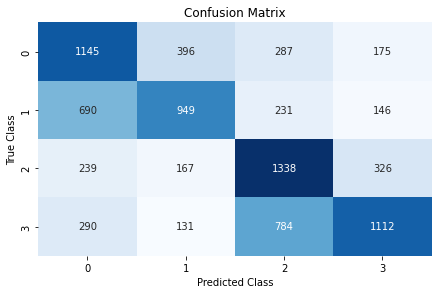

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
matriz = confusion_matrix(y_true,y_pred)
dataframe = pd.DataFrame(matriz)

sns.heatmap(dataframe, annot=True ,fmt=".0f", cbar=None, cmap="Blues")
plt.title("Confusion Matrix"), plt.tight_layout()
plt.ylabel("True Class"), plt.xlabel("Predicted Class")
plt.show()

In [14]:
# Recall
from sklearn.metrics import recall_score
recall_score(y_true, y_pred, average=None)

array([0.57164254, 0.47073413, 0.64637681, 0.47993095])

In [15]:
# Precision
from sklearn.metrics import precision_score
precision_score(y_true, y_pred, average=None)

array([0.48434856, 0.57760195, 0.50681818, 0.63217737])

In [16]:
# F1: sklearn
from sklearn.metrics import f1_score
f1_score(y_true, y_pred, average=None)

array([0.52438745, 0.51872096, 0.56815287, 0.54563297])

In [18]:
# Probamos el modelo con los datos de validación
import pandas as pd
from sklearn.metrics import confusion_matrix

DATASET_VAL = '/kaggle/input/empathetic/ED_valid_p.csv'
df_test = pd.read_csv(DATASET_VAL,sep=';')


y_true = []
y_pred = []
for index, row in df_test.iterrows(): 
    turno1 = row['utterance']
    turno2 = row['utterance2']  
    y_true.append(row['emotion'])
    
    emotion_pred = classifySentiment_loaded(turno1,turno2).item()
    y_pred.append(emotion_pred)
    
# Creamos la matriz de confusión
confusion_matrix(y_true,y_pred)

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

array([[1299,  478,  327,  168],
       [ 790, 1159,  265,  163],
       [ 224,  168, 1533,  315],
       [ 357,  148,  721, 1155]])

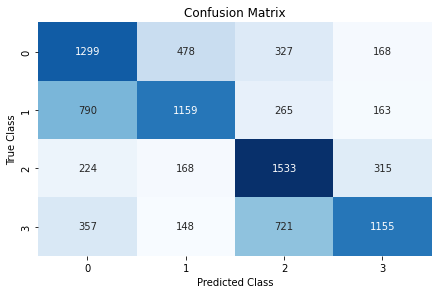

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
matriz = confusion_matrix(y_true,y_pred)
dataframe = pd.DataFrame(matriz)

sns.heatmap(dataframe, annot=True,fmt=".0f", cbar=None, cmap="Blues")
plt.title("Confusion Matrix"), plt.tight_layout()
plt.ylabel("True Class"), plt.xlabel("Predicted Class")
plt.show()

In [20]:
# Accuracy
from sklearn.metrics import accuracy_score
accuracy_score(y_true, y_pred)

0.5551240560949299

In [21]:
# Recall
from sklearn.metrics import recall_score
recall_score(y_true, y_pred, average=None)

array([0.57174296, 0.4875894 , 0.684375  , 0.4850903 ])

In [22]:
# Precision
from sklearn.metrics import precision_score
precision_score(y_true, y_pred, average=None)

array([0.48651685, 0.59344598, 0.53865074, 0.64131038])

In [23]:
# F1: sklearn
from sklearn.metrics import f1_score
f1_score(y_true, y_pred, average=None)

array([0.5256981 , 0.53533487, 0.6028313 , 0.55236729])

In [18]:
# Probamos el modelo
turno1 = "My friend's boyfriend recently made a pass at me. I'm married, and I also am really good friend's with his girlfriend so I felt really bad. I made sure he knew I was loyal and honest to both!"
turno2 = 'Thats horrible. Did you tell on him?'

emocion = classifySentiment_loaded(turno1,turno2).item()
print(emocion)

Nivel de emoción tensor([2], device='cuda:0')
2
